### 1. Impot Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import eda_helper_functions
from sklearn.ensemble import IsolationForest

### 2. Read the training Data

In [2]:
file_path = r"D:\CampusX\Flight_Sagemaker_Project\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-18,Banglore,Delhi,17:00:00,19:50:00,170,0.0,No Info,6961
1,Jet Airways,2019-04-24,Banglore,Delhi,08:20:00,11:20:00,180,0.0,In-flight meal not included,4544
2,Jet Airways,2019-05-03,Banglore,Delhi,19:50:00,22:50:00,180,0.0,No Info,7229
3,Air India,2019-06-15,Banglore,Delhi,17:00:00,19:45:00,165,0.0,No Info,7171
4,Air India,2019-04-09,Delhi,Cochin,07:00:00,19:15:00,735,1.0,No Info,6674
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-05-03,Chennai,Kolkata,14:45:00,17:05:00,140,0.0,No Info,3858
636,Multiple Carriers,2019-03-21,Delhi,Cochin,11:40:00,21:00:00,560,1.0,No Info,7215
637,Indigo,2019-06-03,Mumbai,Hyderabad,12:00:00,13:30:00,90,0.0,No Info,2754
638,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093


### 2.1 Fixing Data Types

In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
    col: pd.to_datetime(train.loc[:, col], dayfirst = True)
    for col in ['date_of_journey', 'dep_time', 'arrival_time']
})
train.dtypes

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13844\2188188342.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  col: pd.to_datetime(train.loc[:, col], dayfirst = True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13844\2188188342.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(train.loc[:, col], dayfirst = True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13844\2188188342.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col: pd.to_datetime(train.loc[:, col], dayfirst = True)


airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

### 3. High-level Summary of Data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [6]:
train.describe(include = 'number')  # For every numeric variable give some numeric stats


,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,642.250000,0.800000,8874.737500
std,502.954355,0.655302,4433.153307
min,75.000000,0.000000,1965.000000
25%,170.000000,0.000000,4982.250000
50%,530.000000,1.000000,8079.000000
75%,911.250000,1.000000,12398.750000
max,2300.000000,3.000000,27210.000000


In [7]:
train.describe(include='O') # stats for categorical variables

,airline,source,destination,additional_info
count,640,640,640,640
unique,8,5,6,4
top,Jet Airways,Delhi,Cochin,No Info
freq,230,259,259,487


In [8]:
# want to include total_stops also as a categorical variable
(
    train.assign(total_stops=train['total_stops'].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,4
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,230,259,259,349.0,487


### 4. High-level analysis of Missing Values

In [9]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


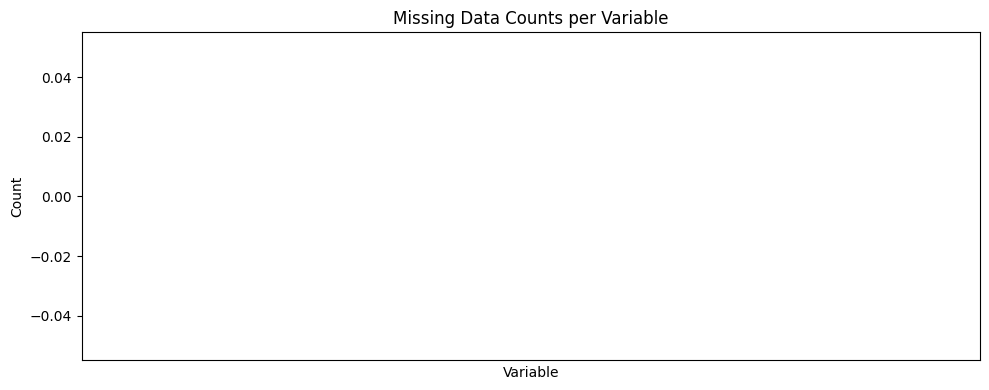

In [10]:
eda_helper_functions.plot_missing_info(train)

### 5. High-level analysis of Outliers

In [11]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [12]:
(
    train.assign(outlier=forest.fit_predict(
        train
        .drop(columns='price')
        .select_dtypes(include='number')
    ))
    .query('outlier == -1')
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
8,Air India,2019-05-01,Delhi,Cochin,2024-10-12 22:00:00,2024-10-12 19:15:00,1275,2.0,No Info,11281,-1
12,Jet Airways,2019-03-21,Delhi,Cochin,2024-10-12 16:00:00,2024-10-12 18:50:00,1610,1.0,No Info,12557,-1
13,Jet Airways,2019-06-15,Delhi,Cochin,2024-10-12 11:45:00,2024-10-12 04:25:00,1000,2.0,No Info,13882,-1
14,Jet Airways,2019-05-21,Delhi,Cochin,2024-10-12 18:15:00,2024-10-12 19:00:00,1485,1.0,No Info,16079,-1
20,Vistara,2019-05-09,Chennai,Kolkata,2024-10-12 07:05:00,2024-10-12 09:20:00,135,0.0,No Info,3687,-1
...,...,...,...,...,...,...,...,...,...,...,...
633,Air India,2019-05-01,Mumbai,Hyderabad,2024-10-12 19:30:00,2024-10-12 20:45:00,75,0.0,No Info,3100,-1
635,Indigo,2019-05-03,Chennai,Kolkata,2024-10-12 14:45:00,2024-10-12 17:05:00,140,0.0,No Info,3858,-1
637,Indigo,2019-06-03,Mumbai,Hyderabad,2024-10-12 12:00:00,2024-10-12 13:30:00,90,0.0,No Info,2754,-1
638,Jet Airways,2019-03-21,Delhi,Cochin,2024-10-12 10:45:00,2024-10-12 18:50:00,1925,2.0,No Info,11093,-1


### 6. Pair Plot

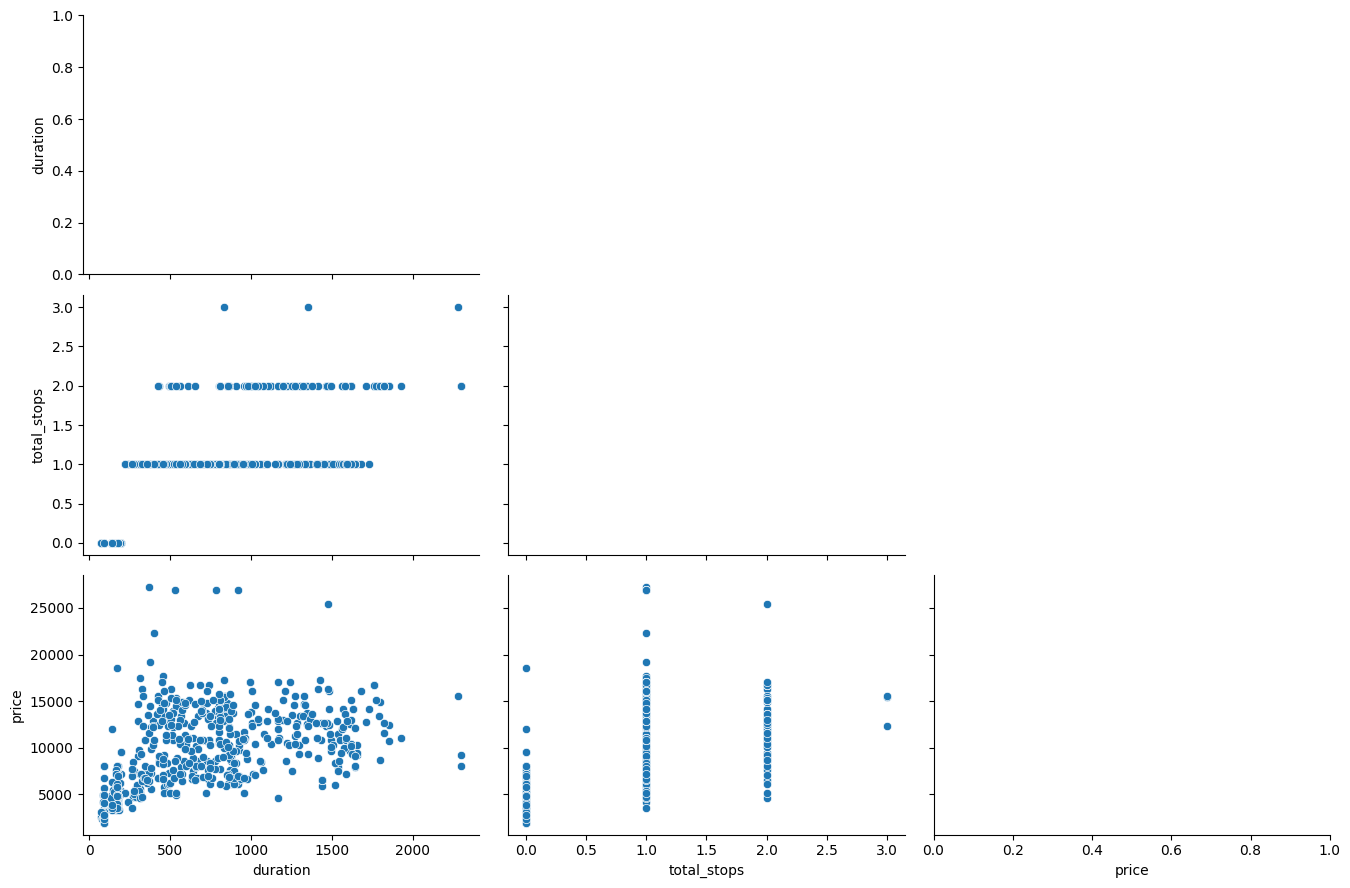

In [13]:
eda_helper_functions.pair_plots(train)

### 7. Correlation Analysis

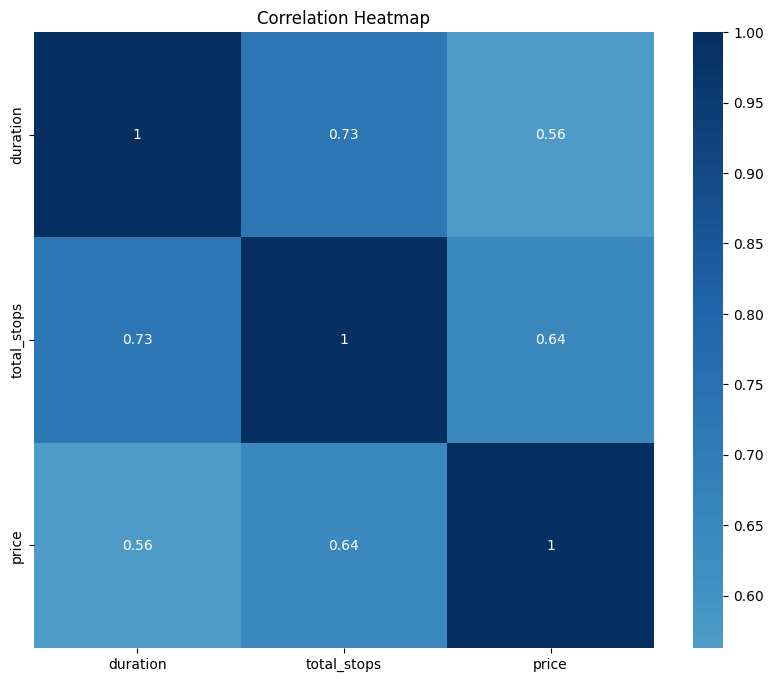

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
# Calculate correlation matrix
corr_matrix = train.select_dtypes(include='number').corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0)
plt.title('Correlation Heatmap')
plt.show()


In [15]:
#train.corr(method="spearman")

In [16]:

#eda_helper_functions.cramersV_heatmap(train)

### 8. Detailed Analayssis

In [17]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

#### 8.1 Airline

In [18]:
train.airline

0              Air India
1            Jet Airways
2            Jet Airways
3              Air India
4              Air India
             ...        
635               Indigo
636    Multiple Carriers
637               Indigo
638          Jet Airways
639            Air India
Name: airline, Length: 640, dtype: object

In [19]:
eda_helper_functions.cat_summary(train,'airline')

0              Air India
1            Jet Airways
2            Jet Airways
3              Air India
4              Air India
             ...        
635               Indigo
636    Multiple Carriers
637               Indigo
638          Jet Airways
639            Air India
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,230


,count,percentage
category,,
Jet Airways,230,0.359375
Indigo,116,0.181250
Air India,103,0.160938
Multiple Carriers,67,0.104688
Spicejet,63,0.098437
Vistara,28,0.043750
Air Asia,22,0.034375
Goair,11,0.017188


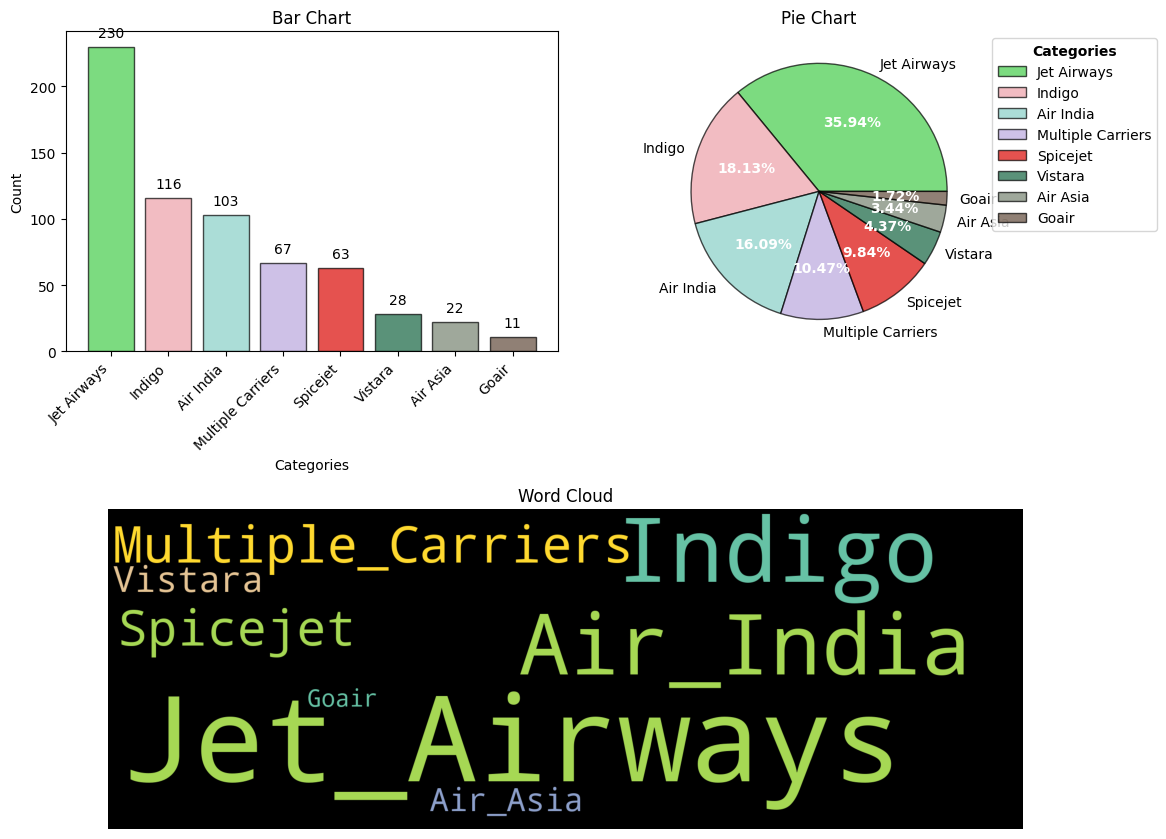

In [20]:
eda_helper_functions.cat_univar_plots(train, "airline")

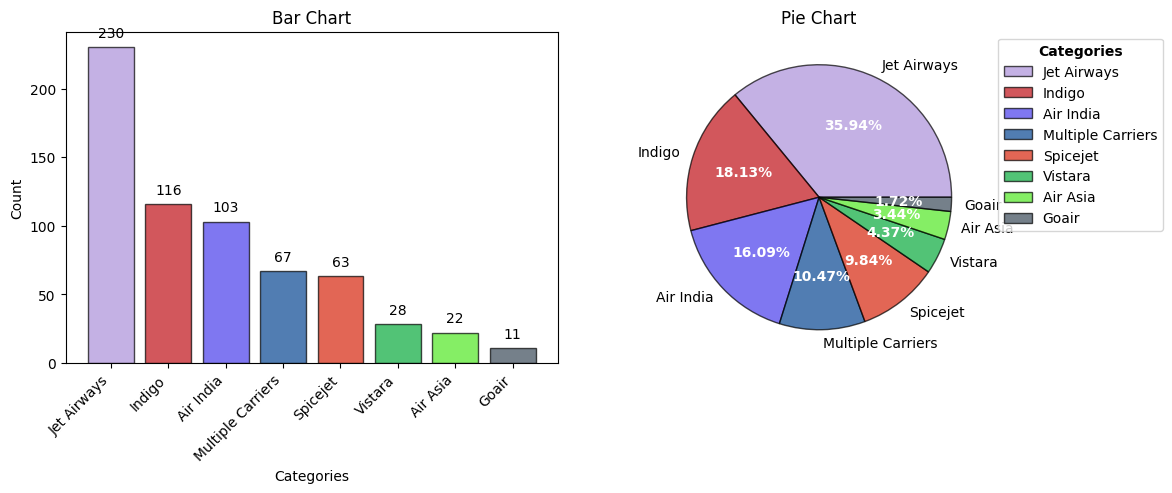

In [21]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False)

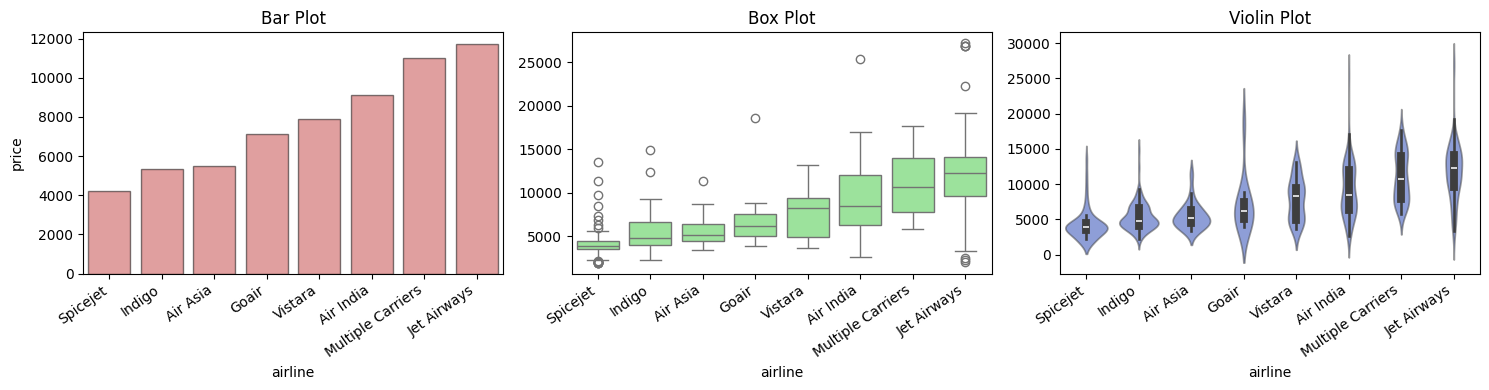

In [22]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var='price',
    cat_var='airline'
)

 - Based on airline, prices are varying with help of airline barplot

In [23]:
eda_helper_functions.num_cat_hyp_testing(train, 'price', 'airline')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 66.01480832008215
- p-value              : 3.0665285162025713e-71
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 307.3609462403659
- p-value              : 1.6198140980205937e-62
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


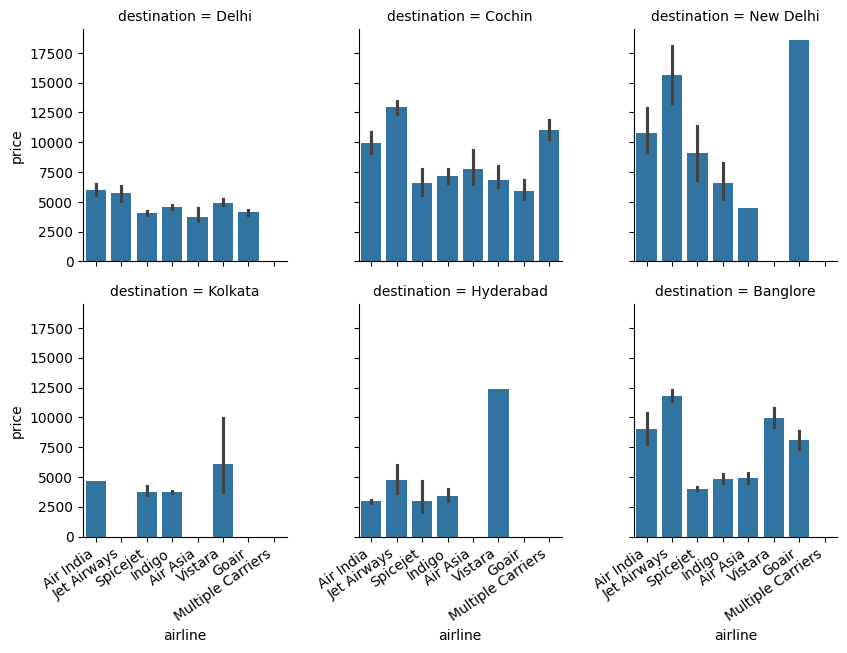

In [24]:
airline_grid = sns.FacetGrid( # FacetGrid is very helpful for analysising multi-variate
    data=train,
    col='destination',
    col_wrap=3,
    sharey=True
)
airline_grid.map(sns.barplot, 'airline', 'price')

for ax in airline_grid.axes[3:]: # acessing the from 4th image of axes
    eda_helper_functions.rotate_xlabels(ax)

#### 8.2 date_of_journey

In [25]:
train.date_of_journey

0     2019-06-18
1     2019-04-24
2     2019-05-03
3     2019-06-15
4     2019-04-09
         ...    
635   2019-05-03
636   2019-03-21
637   2019-06-03
638   2019-03-21
639   2019-05-09
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

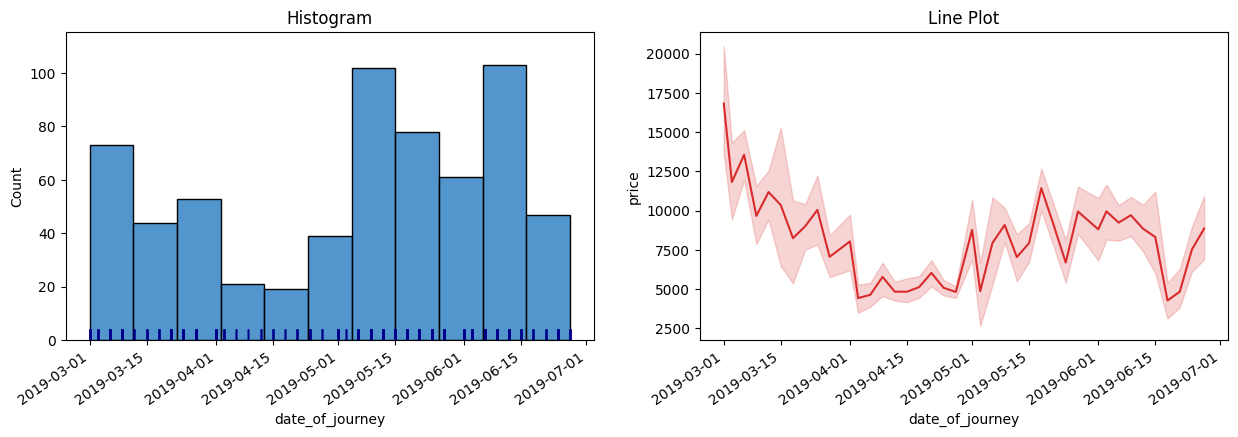

In [26]:
eda_helper_functions.dt_univar_plots(train, 'date_of_journey', 'price')

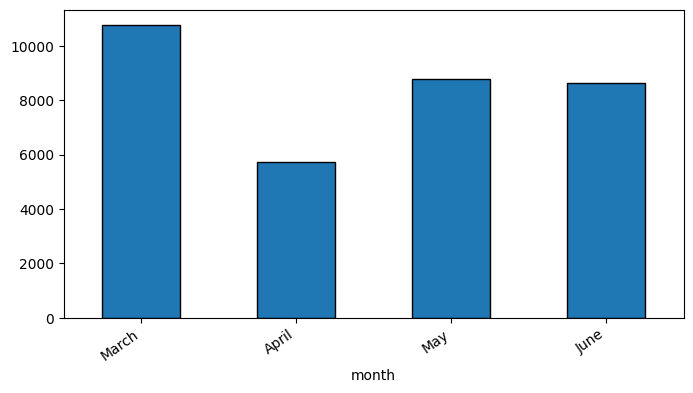

In [27]:
(
    train
    .groupby(pd.Grouper(key='date_of_journey', freq='M'))
    .price.mean()
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index='month')
    .plot(
        kind='bar',
        figsize=(8,4),
        edgecolor='black'
    )
)
ax = plt.gca() # gca mean get the current axes
eda_helper_functions.rotate_xlabels(ax)

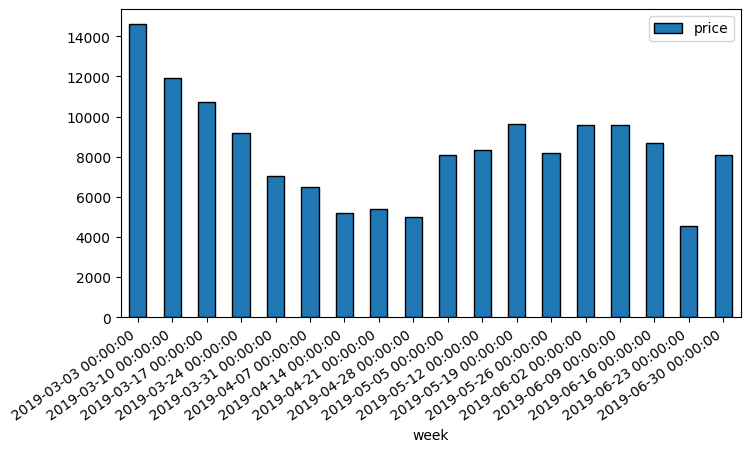

In [28]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

In [29]:
(
    train
    .groupby([pd.Grouper(key='date_of_journey', freq='M'), 'source'])
    .price.mean()
    .unstack(fill_value=0)
)

source,Banglore,Chennai,Delhi,Kolkata,Mumbai
date_of_journey,,,,,
2019-03-31,12650.452830,4187.714286,11614.793651,8881.500000,4904.083333
2019-04-30,5018.214286,0.000000,6008.214286,6920.560000,3487.333333
2019-05-31,4684.100000,4409.272727,11027.134831,9539.647059,3439.470588
2019-06-30,5377.888889,3720.818182,10024.849462,9653.062500,3155.250000


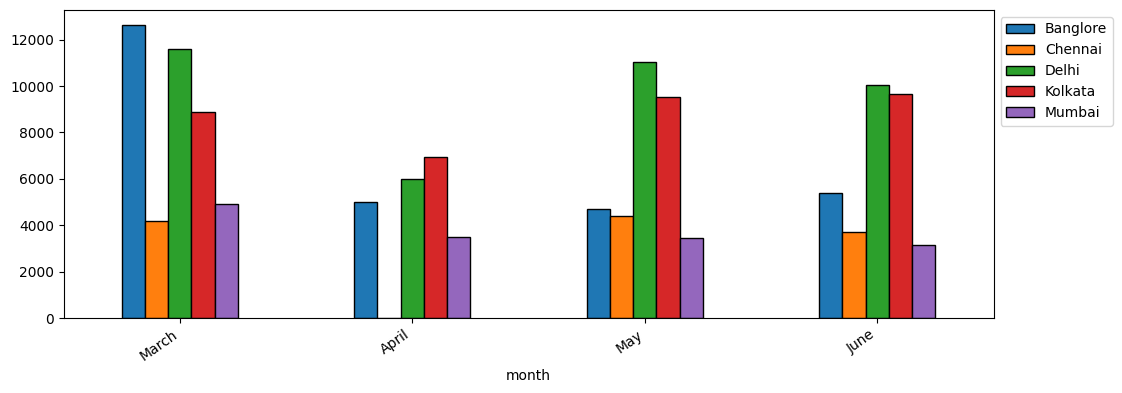

In [30]:
(
    train
    .groupby([pd.Grouper(key='date_of_journey', freq='M'), 'source'])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index='month')
    .plot(
        kind='bar',
        figsize=(12,4),
        edgecolor='black'
    )
)
ax = plt.gca()
ax.legend(
    loc = 'upper left', # locating the legend at upper left inside the boundary
    bbox_to_anchor=(1, 1) # sending out of the boundary
)

eda_helper_functions.rotate_xlabels(ax)

#### 8.3 dep_time

In [31]:
train.dep_time

0     2024-10-12 17:00:00
1     2024-10-12 08:20:00
2     2024-10-12 19:50:00
3     2024-10-12 17:00:00
4     2024-10-12 07:00:00
              ...        
635   2024-10-12 14:45:00
636   2024-10-12 11:40:00
637   2024-10-12 12:00:00
638   2024-10-12 10:45:00
639   2024-10-12 12:55:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

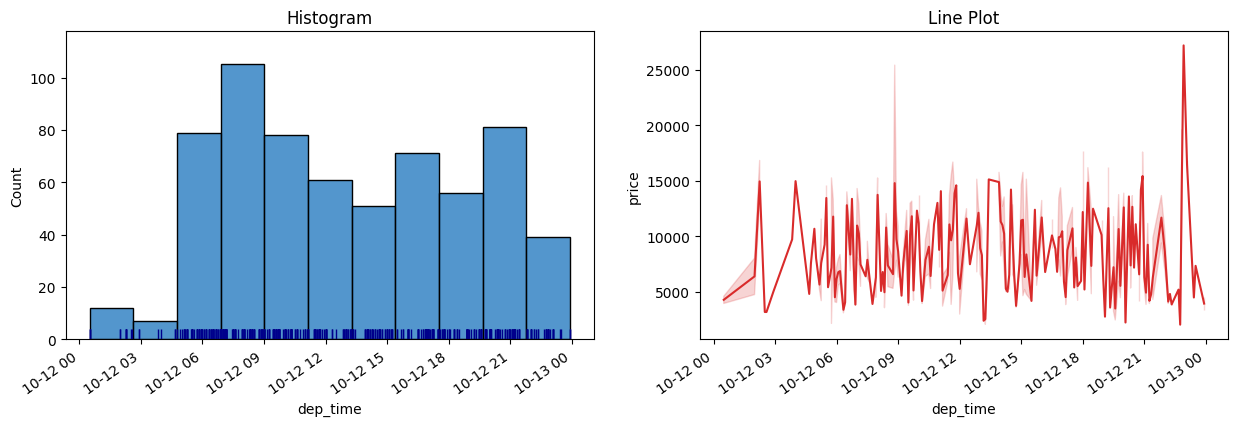

In [32]:
eda_helper_functions.dt_univar_plots(train, 'dep_time', 'price')

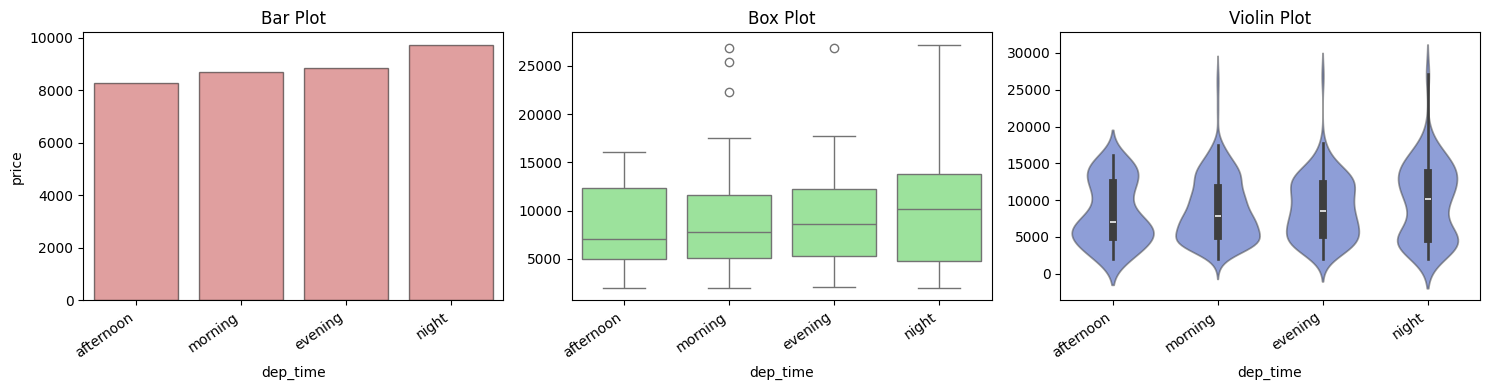

In [35]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

#### 8.4 duration

In [36]:
train.duration

0       170
1       180
2       180
3       165
4       735
       ... 
635     140
636     560
637      90
638    1925
639    1820
Name: duration, Length: 640, dtype: int64

In [37]:
eda_helper_functions.num_summary(train, 'duration')

0       170
1       180
2       180
3       165
4       735
       ... 
635     140
636     560
637      90
638    1925
639    1820
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.00
5,90.00
10,140.00
25,170.00
50,530.00
75,911.25
90,1475.50
95,1615.00
99,1820.00


,value
mean,642.250000
trimmed mean (5%),610.572917
trimmed mean (10%),582.578125
median,530.000000


,value
var,252963.082942
std,502.954355
IQR,741.250000
mad,360.000000
coef_variance,0.783113


,value
skewness,0.815464
kurtosis,-0.262089


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 1.203254481420497e-20
Test Statistic       : 0.8933463096618652
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 21.777556403387507
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


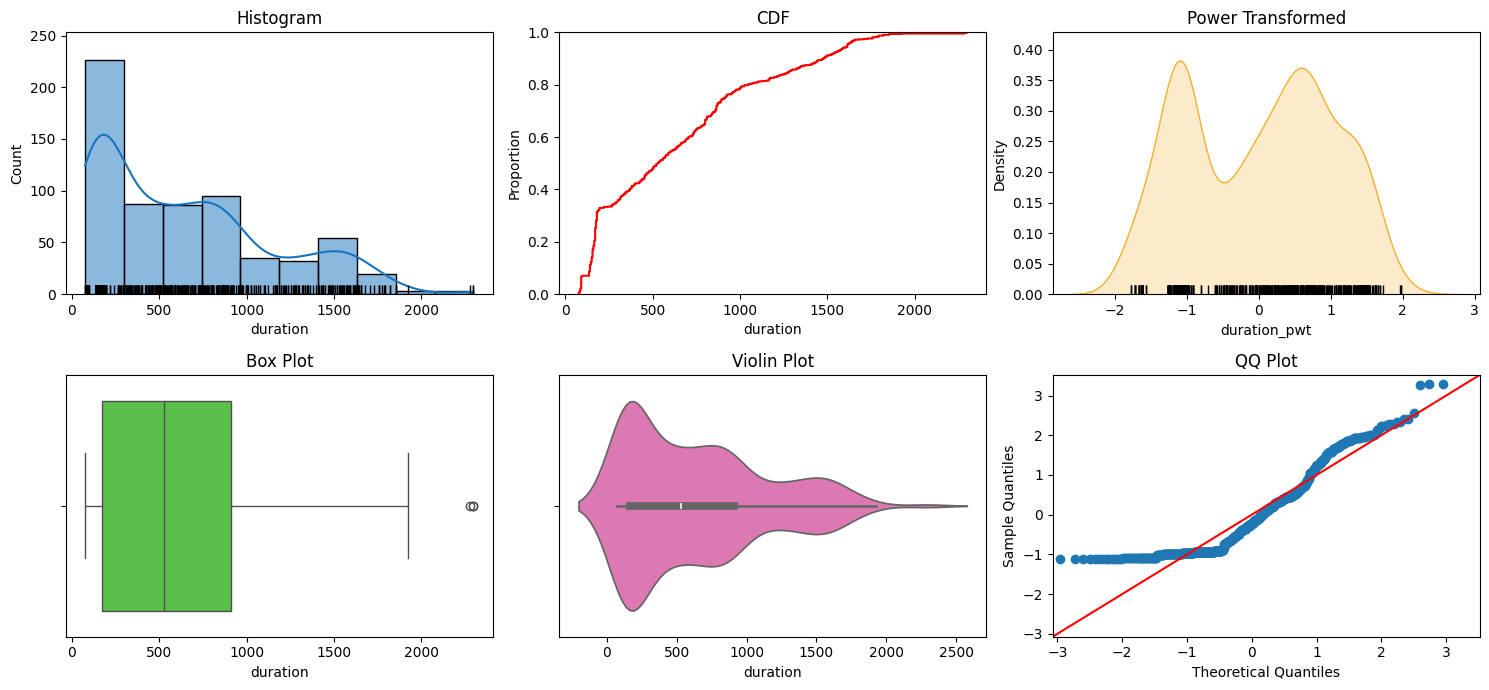

In [38]:
eda_helper_functions.num_univar_plots(train, 'duration')

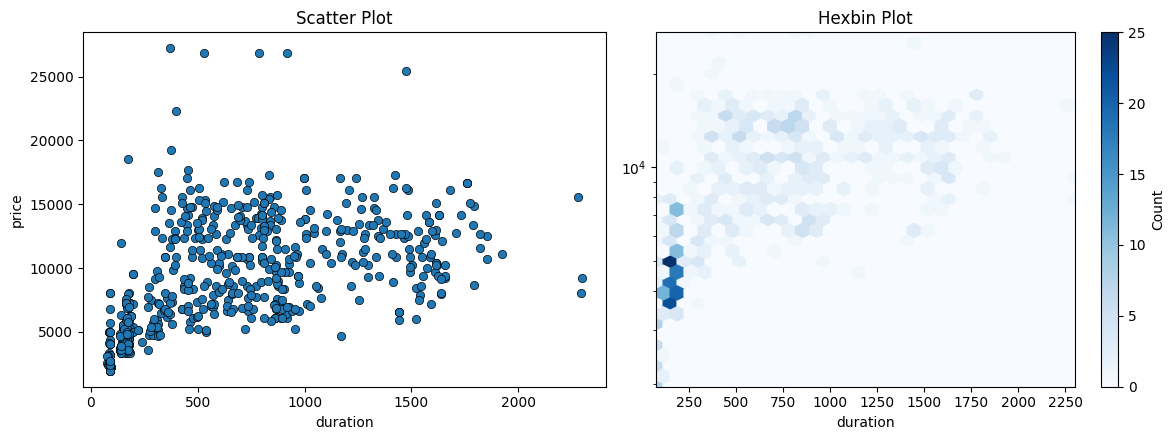

In [39]:
eda_helper_functions.num_bivar_plots(train, 'duration', 'price',
                                     hexbin_kwargs=dict(
                                         yscale='log',
                                         gridsize=30,
                                         cmap='Blues'))

In [40]:
eda_helper_functions.num_num_hyp_testing(train, 'price', 'duration')

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5626562124844422
- p-value              : 1.0295008597747305e-54
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.7110625753182659
- p-value              : 1.1350678229482652e-99
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


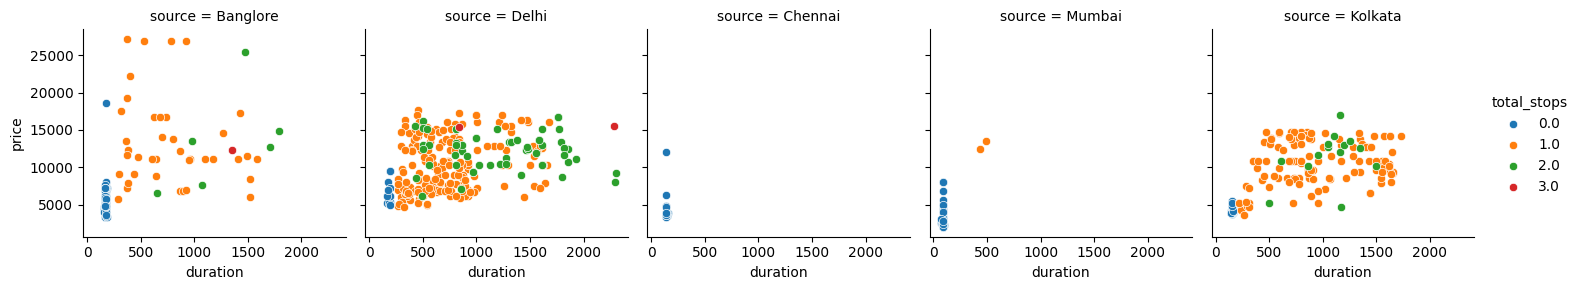

In [41]:
duration_grid = sns.FacetGrid(
    data=train,
    col='source',
    hue='total_stops',
    sharey=True
)
duration_grid.map(sns.scatterplot, 'duration', 'price')

duration_grid.add_legend()

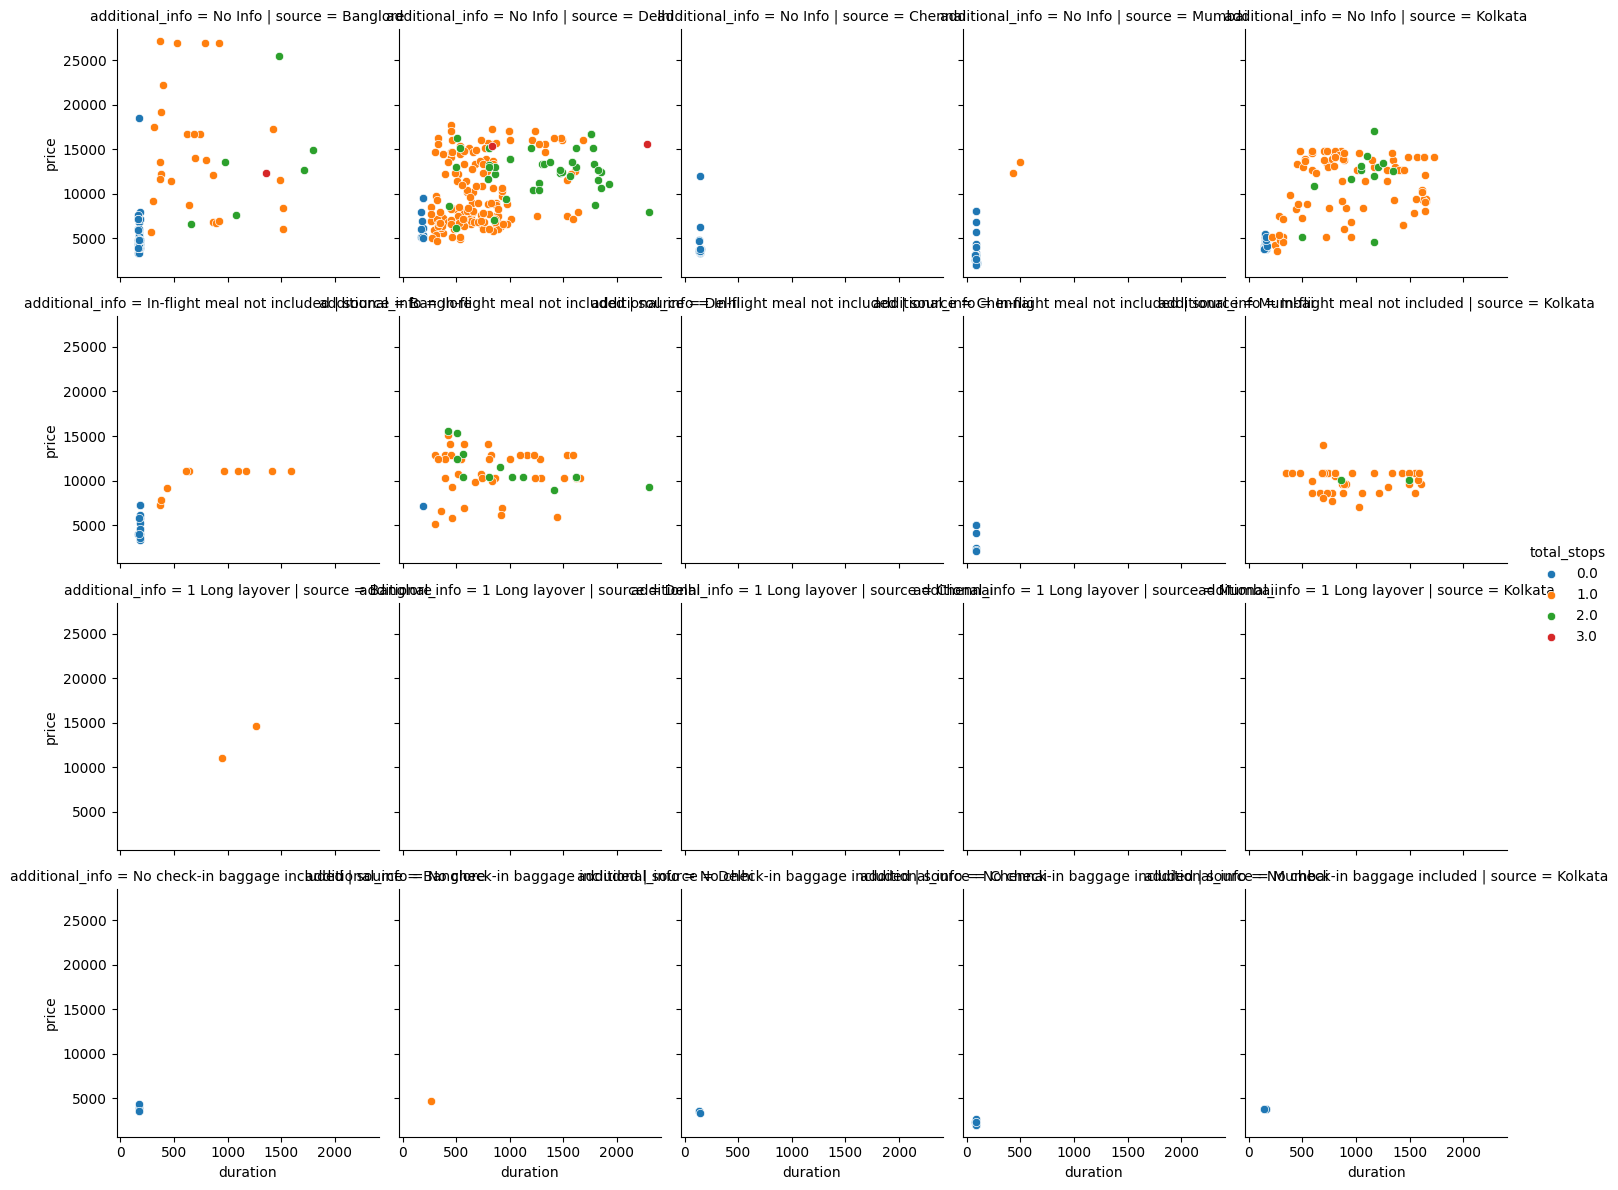

In [42]:
duration_grid = sns.FacetGrid(
    data=train,
    col='source',
    row="additional_info",
    hue='total_stops',
    sharey=True
)
duration_grid.map(sns.scatterplot, 'duration', 'price')

duration_grid.add_legend()

### 9.Automated EDA

 - libraries which are used for automated EDA are: PandasProfiling(ydata-profiling, Sweetviz, Autoviz, D-Tale)

In [43]:
from ydata_profiling import ProfileReport

In [44]:
report = ProfileReport(train)

In [45]:
report.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 144.86it/s]
